# Eletrobras - Historical Weather Forecasts Explorer

This notebook provides visualisation tools for forecasts stored in `graphnn-historical-weather-forecasts`

In [ ]:
# @title Installs.

!pip install gcsfs zarr dask

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 27.5 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=1cf7f216cb1bd902b02f47ba008800f650c64e4f78ee15b40f2bd7d3947cb489
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [ ]:
# @title Imports.
import fsspec
import pandas as pd
import xarray as xa
import numpy as np
import matplotlib.pyplot as plt
from google.colab import auth
from collections import OrderedDict

In [ ]:
# @title Authenticate user and check access.
auth.authenticate_user()
fs = fsspec.filesystem('gs')
BUCKET = "gs://graphnn-historical-weather-forecasts"
fs.ls(BUCKET)

['graphnn-historical-weather-forecasts/GraphNN_Historic_Weather_Forecasts_Explorer_(GCP).ipynb',
 'graphnn-historical-weather-forecasts/LICENSE.apachev2',
 'graphnn-historical-weather-forecasts/LICENSE.cc_by',
 'graphnn-historical-weather-forecasts/README.html',
 'graphnn-historical-weather-forecasts/README.md',
 'graphnn-historical-weather-forecasts/era5',
 'graphnn-historical-weather-forecasts/index.html',
 'graphnn-historical-weather-forecasts/operational']

In [ ]:
# @title Data paths.

ERA5_MODEL_RANGES = OrderedDict({
    "Trained on ERA5<2022": {
        "training_end": pd.Timestamp("2022-01-01"),
        "init_start": pd.Timestamp("2021-12-01"),
        "init_end": pd.Timestamp("2022-12-31"),
    },
    "Trained on ERA5<2021": {
        "training_end": pd.Timestamp("2021-01-01"),
        "init_start": pd.Timestamp("2020-12-01"),
        "init_end": pd.Timestamp("2022-01-22"),
    },
    "Trained on ERA5<2020": {
        "training_end": pd.Timestamp("2020-01-01"),
        "init_start": pd.Timestamp("2019-12-01"),
        "init_end": pd.Timestamp("2021-01-22"),
    },
    "Trained on ERA5<2019": {
        "training_end": pd.Timestamp("2019-01-01"),
        "init_start": pd.Timestamp("2018-12-01"),
        "init_end": pd.Timestamp("2020-01-22"),
    },
    "Trained on ERA5<2018": {
        "training_end": pd.Timestamp("2018-01-01"),
        "init_start": pd.Timestamp("2017-12-01"),
        "init_end": pd.Timestamp("2019-01-22"),
    },
})
OPERATIONAL_MODEL_RANGES = OrderedDict({
    "Trained on HRES-fc-0<2023": {
        "training_end": pd.Timestamp("2023-01-01"),
        "init_start": pd.Timestamp("2022-12-01"),
        "init_end": pd.Timestamp("2023-12-22"),
    },
    "Trained on HRES-fc-0<2022": {
        "training_end": pd.Timestamp("2022-01-01"),
        "init_start": pd.Timestamp("2021-12-01"),
        "init_end": pd.Timestamp("2022-12-22"),
    },
    "Trained on HRES-fc-0<2021": {
        "training_end": pd.Timestamp("2021-01-01"),
        "init_start": pd.Timestamp("2020-12-01"),
        "init_end": pd.Timestamp("2022-01-22"),
    },
    "Trained on HRES-fc-0<2020": {
        "training_end": pd.Timestamp("2020-01-01"),
        "init_start": pd.Timestamp("2019-12-01"),
        "init_end": pd.Timestamp("2021-01-22"),
    },
})

def get_path_from_date(model_type, init_date):
  """Chooses forecast that corresponds to given initialization.

  In particular, this selects the forecast initialised at this date from the
  model that has been trained up to the most recent cutoff before this date.
  This ensures that the date does not lie within the models training window.
  """

  if model_type == "ERA5":
    model_ranges = ERA5_MODEL_RANGES
  elif model_type == "Operational":
    model_ranges = OPERATIONAL_MODEL_RANGES
  # Check within range.
  assert init_date >= list(model_ranges.items())[-1][1]["training_end"]
  assert init_date <= list(model_ranges.items())[0][1]["init_end"]

  # Traverse OrderedDict until most recent model found with init time
  # outside of training window.
  for label, ranges in model_ranges.items():
    if init_date > ranges["training_end"]:
      start = ranges["init_start"].strftime('%Y-%m-%d')
      end = ranges["init_end"].strftime('%Y-%m-%d')
      path = f"{BUCKET}/{str.lower(model_type)}/forecasts_10d/date_range_{start}_{end}_6_hours.zarr"
      return label, path


In [ ]:
# @title Lazily load Zarr forecasts.

# Note (where valid = outside training window):
# Range of valid Operational forecast inits: 2020-01-01 to 2023-12-22
# Range of valid ERA5 forecasts inits: 2018-01-01 to 2022-12-31

# Configure model type.
model_type = "ERA5" # @param ['ERA5', 'Operational']

# Configure init date and get corresponding path.
init_date = '2022-01-01'  # @param {type: "date"}
label, path = get_path_from_date(model_type, pd.Timestamp(init_date))

# Load data.
init_time = '12z' # @param ['00z', '06z', '12z', '18z']
print(f"Loading forecast initialised on {init_date}T{init_time} for {label} from {path}")
forecasts_dataset = xa.open_zarr(path, consolidated=True)
time = pd.Timestamp(f"{init_date}T{init_time[:2]}")
forecast = forecasts_dataset.sel(time=time)
forecast

Loading forecast initialised on 2022-01-01T12z for Trained on ERA5<2021 from gs://graphnn-historical-weather-forecasts/era5/forecasts_10d/date_range_2020-12-01_2022-01-22_6_hours.zarr


<xarray.Dataset> Size: 38GB
Dimensions:                  (prediction_timedelta: 40, lat: 721, lon: 1440,
                              level: 37)
Coordinates:
  * lat                      (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.75 90.0
    lead_time_secs           (prediction_timedelta) int64 320B dask.array<chunksize=(1,), meta=np.ndarray>
  * level                    (level) int64 296B 1 2 3 5 7 ... 925 950 975 1000
  * lon                      (lon) float32 6kB 0.0 0.25 0.5 ... 359.5 359.8
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 320B 06:0...
    time                     datetime64[ns] 8B 2022-01-01T12:00:00
Data variables:
    10m_u_component_of_wind  (prediction_timedelta, lat, lon) float32 166MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind  (prediction_timedelta, lat, lon) float32 166MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature           (prediction_timedelta, lat, lon) float32 166MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    geopotential             (prediction_timedelta, level, lat, lon) float32 6GB dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    mean_sea_level_pressure  (prediction_timedelta, lat, lon) float32 166MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    specific_humidity        (prediction_timedelta, level, lat, lon) float32 6GB dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    temperature              (prediction_timedelta, level, lat, lon) float32 6GB dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    total_precipitation_6hr  (prediction_timedelta, lat, lon) float32 166MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    u_component_of_wind      (prediction_timedelta, level, lat, lon) float32 6GB dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind      (prediction_timedelta, level, lat, lon) float32 6GB dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity        (prediction_timedelta, level, lat, lon) float32 6GB dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
Attributes:
    end_forecast_date:        2022-01-22
    evaluation_wid:           7
    evaluation_xid:           99140631
    label:                    forecasts_10d
    model_input_data_type:    default
    model_wid:                3
    model_xid:                50432171
    random_seed:              0
    start_forecast_date:      2020-12-01
    time_between_forecasts:   6 hours
    use_best:                 False
    use_synthetic_radiation:  True

In [ ]:
# Define location options with names and coordinates
location_options = {
    "Foz de Iguazu": (-25.47, -54.54),
    "Grajau": (-22.93, -43.26),
    "Campinas": (-22.77, -47.00),
    "Sao Jose": (-22.75, -43.33),
    "Tocantins": (-10.66, -48.29),
    "Paraíba do Sul": (-22.16, -43.29)
}

In [ ]:
# @title Get some forecasts and print predicted values.
variable = "2m_temperature"  # @param ['2m_temperature', 'total_precipitation_6hr', '10m_u_component_of_wind', '10m_v_component_of_wind']
location_name = "Foz de Iguazu" # @param {type:"string", allow-input: false} ["Foz de Iguazu", "Grajau", "Campinas", "Sao Jose", "Tocantins", "Paraíba do Sul"]

horizons = ['6h', '12h', '1d', '2d', '3d', '5d', '10d'] # @param

latitude, longitude = location_options[location_name]
predicted_values = []

for horizon in horizons:
  data_forecast = forecast[variable].sel(prediction_timedelta=horizon, lat=latitude, lon=longitude, method="nearest")

  # Convert to Celsius if variable is temperature
  if variable == "2m_temperature":
    data_forecast = data_forecast - 273.15  # Kelvin to Celsius conversion

  print(f"Predicted {variable} at {location_name} for horizon {horizon}: {data_forecast.compute().item()}")  # Convert to NumPy array


Predicted 2m_temperature at Foz de Iguazu for horizon 6h: 20.651941299438477
Predicted 2m_temperature at Foz de Iguazu for horizon 12h: 20.152551651000977
Predicted 2m_temperature at Foz de Iguazu for horizon 1d: 20.101587295532227
Predicted 2m_temperature at Foz de Iguazu for horizon 2d: 20.558923721313477
Predicted 2m_temperature at Foz de Iguazu for horizon 3d: 20.45574378967285
Predicted 2m_temperature at Foz de Iguazu for horizon 5d: 21.5427188873291
Predicted 2m_temperature at Foz de Iguazu for horizon 10d: 22.09783363342285


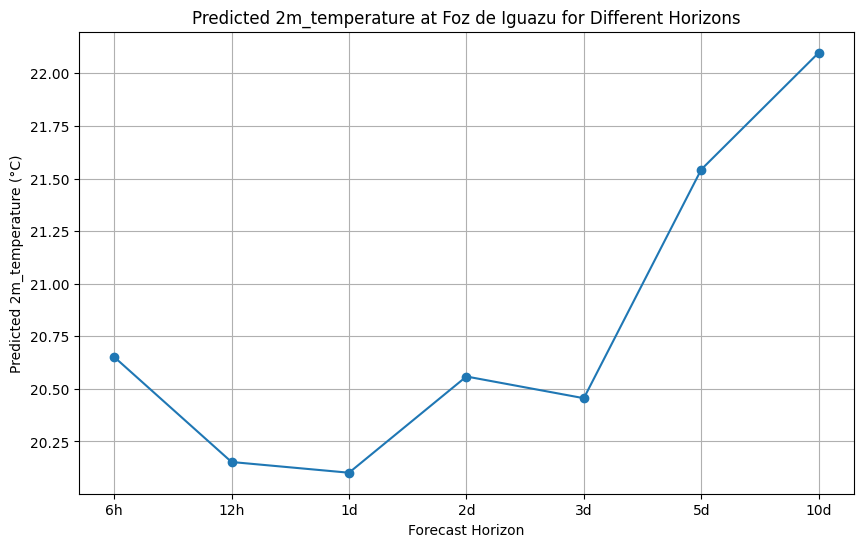

In [ ]:
predicted_values = []
for horizon in horizons:
    data_forecast = forecast[variable].sel(prediction_timedelta=horizon, lat=latitude, lon=longitude, method="nearest")

    # Convert to Celsius if variable is temperature
    if variable == "2m_temperature":
        value = data_forecast.compute().item() - 273.15
    else:
        value = data_forecast.compute().item()

    predicted_values.append(value)  # Append the value (Celsius or original)

plt.figure(figsize=(10, 6))
plt.plot(horizons, predicted_values, marker='o')
plt.xlabel("Forecast Horizon")

# Update y-axis label if temperature
if variable == "2m_temperature":
    plt.ylabel(f"Predicted {variable} (°C)")
else:
    plt.ylabel(f"Predicted {variable}")

plt.title(f"Predicted {variable} at {location_name} for Different Horizons")
plt.grid(True)
plt.show()